<a href="https://colab.research.google.com/github/periwinklemctartins/Coronavirus--Propogation-Simulation/blob/master/AutomaticDifferentiationUsingPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib           
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

#Connections between Canadian Provinces
A = torch.tensor([[1,     1,     1,     0,     0,     0,     0,     0,     1,     0,     1,     1,     1],
                  [1,     1,     1,     0,     0,     1,     0,     0,     1,     0,     1,     1,     0],
                  [1,     1,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     0],
                  [0,     0,     0,     1,     1,     0,     0,     0,     1,     1,     1,     0,     0],
                  [0,     0,     0,     1,     1,     0,     1,     0,     1,     1,     1,     0,     0],
                  [0,     1,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     1],
                  [0,     0,     0,     0,     1,     0,     1,     0,     1,     1,     1,     0,     0],
                  [0,     0,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     1],
                  [1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
                  [0,     0,     0,     1,     1,     0,     1,     0,     1,     1,     1,     0,     0],
                  [1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
                  [1,     1,     1,     0,     0,     1,     0,     1,     1,     0,     1,     1,     0],
                  [1,     0,     0,     0,     0,     1,     0,     1,     1,     0,     1,     0,     1]]);

#Number of connections each province has                  
L = torch.tensor([[6,    -1,    -1,     0,     0,     0,     0,     0,    -1,     0,    -1,    -1,    -1], 
                  [-1,    6,    -1,     0,     0,    -1,     0,     0,    -1,     0,    -1,    -1,     0],
                  [-1,    1,     7,     0,     0,    -1,     0,    -1,    -1,     0,    -1,    -1,     0],
                  [0,     0,     0,     4,    -1,     0,     0,     0,    -1,    -1,    -1,     0,     0],
                  [0,     0,     0,    -1,     5,     0,    -1,     0,    -1,    -1,    -1,     0,     0],
                  [0,    -1,    -1,     0,     0,     7,     0,    -1,    -1,     0,    -1,    -1,    -1],
                  [0,     0,     0,     0,    -1,     0,     4,     0,    -1,    -1,    -1,     0,     0],
                  [0,     0,    -1,     0,     0,    -1,     0,     6,    -1,     0,    -1,    -1,    -1],
                  [-1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    12,    -1,    -1,    -1,   -1],
                  [0,     0,     0,    -1,    -1,     0,    -1,     0,    -1,     5,    -1,     0,     0],
                  [-1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    12,    -1,   -1],
                  [-1,    -1,    -1,     0,     0,    -1,     0,    -1,    -1,     0,    -1,     7,    0],
                  [-1,     0,     0,     0,     0,    -1,     0,    -1,    -1,     0,    -1,     0,    5]]);



In [0]:
def SEImodel(theta,S,E,I):
    alpha = theta[0]
    beta  = theta[1]
    gamma = theta[2]
    mu    = theta[3]
    kE    = theta[4]
    kS    = theta[5]
    kI    = theta[6]
    

    dSdt  = -kS*L[n,n]*S - beta*E*S - gamma*I*S                 # dS/dt
    dEdt  = -kE*L[n,n]*E + beta*E*S  + gamma*I*S - alpha*E      # dE/dt
    dIdt  = -kI*L[n,n]*I + alpha*E - mu*I                       # dI/dt
    
    return dSdt, dEdt, dIdt




In [0]:
def integrateSEI(theta,S0,E0,I0,dt,nt):
    
    # vectors to save the results over time
    Sout = torch.zeros(nt+1); Sout[0] = S0
    Eout = torch.zeros(nt+1); Eout[0] = E0
    Iout = torch.zeros(nt+1); Iout[0] = I0
    
    S = S0; E = E0; I = I0
    for i in range(nt):
        dSdt, dEdt, dIdt = SEImodel(theta,S,E,I)
 

        S += dt*dSdt
        E += dt*dEdt
        I += dt*dIdt

        Sout[i+1] = S
        Eout[i+1] = E
        Iout[i+1] = I
       
    if I >= 0.05:
      print(S,E,I)
      return Sout, Eout, Iout
       
    return Sout, Eout, Iout
    


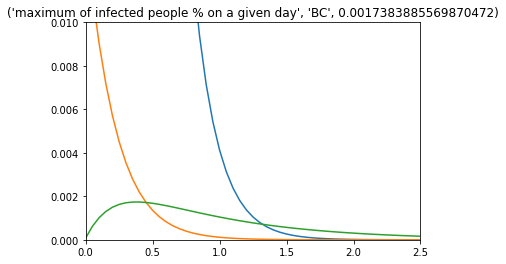

In [4]:
#BC Data as of March 22 2020
PopulationBC = 5071000  #Census Canada
Recovered = 0          #Deceased -> it is impossible to tell if people who have recovered have returned to being infected
Infected = 424 - Recovered    #https://www150.statcan.gc.ca/n1/daily-quotidien/200428/dq200428a-eng.htm
Succeptible = PopulationBC - Infected
#Exposed -> true value is unknown -> assume 15% of those who are exposed are not sick

xmin = 0; xmax = 2.5;
ymin = 0; ymax = .01;

#March 28th highest amount of new infected, data can be found here https://experience.arcgis.com/experience/a6f23959a8b14bfa989e3cda29297ded
#Did not use data from https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection.html because it was less precise than the provincial one shown above

S0 = Succeptible/PopulationBC
E0 = 0.014
I0 = Infected/PopulationBC

# Set the duration for the simulation
dt = 0.05; nt = 100

# We pick the parameters as follows
alpha = .77       #rate of exposed people that get sick
beta  = .5       #rate of interaction of exposed and susceptible
gamma = .1       #rate of interaction infected and susceptible
mu    = 0.015       #rate of pepole who get resistence or die
kE    = 0.6       #Exposed people that move around
kS    = 0.8       #Susceptible people that move around
kI    = 0.2     #Sick people that move around (Diffusion of sick people)
theta = torch.tensor([alpha, beta, gamma, mu, kE, kS, kI])

P = ['AB', 'BC', 'MB', 'NB', 'NL', 'NT', 'NS', 'NU', 'ON', 'PE', 'QC', 'SK', 'YT']
for n in range(1):

  S, E, I = integrateSEI(theta,S0,E0,I0,dt,nt)

  t = np.arange(nt+1)*dt
  title = 'maximum of infected people % on a given day', P[1], torch.max(I).item()
  plt.figure(1)
  plt.title(title)
  plt.plot(t,S,t,E,t,I)

  axes = plt.gca()
  axes.set_xlim([xmin,xmax])
  axes.set_ylim([ymin,ymax])


In [0]:
def ForwardEuler(alpha,beta,gamma,mu,kE,kS,kI,S0,E0,I0,dt,nt):  #Looks to be similar to integrateSEI
    
    S = torch.zeros(nt+1)
    E = torch.zeros(nt+1)
    I = torch.zeros(nt+1)
    S[0] = S0; E[0] = E0; I[0] = I0
    for i in range(nt):
        F = Model(alpha,beta,gamma,mu,kE,kS,kI,S[i],E[i],I[i])
        S[i+1] = S[i] + dt*F[0]
        E[i+1] = E[i] + dt*F[1]
        I[i+1] = I[i] + dt*F[2]
        
    return S, E, I

In [0]:
def Model(alpha,beta,gamma,mu,kE,kS,kI,S,E,I):  #Looks to be similar to SEImodel
    
    F = torch.zeros(3)
    F[0]  = -kS*L[n,n]*S - beta*E*S - gamma*I*S                 # dS/dt
    F[1]  = -kE*L[n,n]*E + beta*E*S  + gamma*I*S - alpha*E      # dE/dt
    F[2]  = -kI*L[n,n]*I + alpha*E - mu*I                       # dI/dt
    
    return F

In [0]:
def loss(alpha,beta,gamma,mu,kE,kS,kI,Sobs,Eobs,Iobs,dt,nt):
    
    Scomp, Ecomp, Icomp = ForwardEuler(alpha,beta,gamma,mu,kE,kS,kI,S0,E0,I0,dt,nt) #comp is computed from code with a chosen beta, gamma 
    phi = torch.sum((Scomp-Sobs)**2) + torch.sum((Ecomp-Eobs)**2) + torch.sum((Icomp-Iobs)**2) #if comp and obs is the same then phi goes to zero
    
    return phi



In [9]:
print(loss(alpha,beta,gamma,mu,kE,kS,kI,S0,E0,I0,dt,nt))

tensor(95.0419)


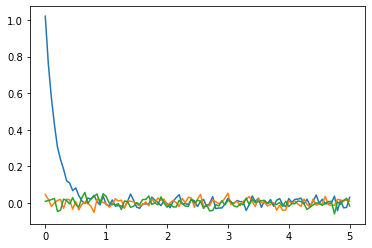

In [7]:
t = np.arange(nt+1); t = t*dt

# Add noise to the data
ndata = S.shape
nS = torch.randn(ndata[0])*0.02
nE = torch.randn(ndata[0])*0.02
nI = torch.randn(ndata[0])*0.02

Sobs = S+nS; Eobs = E+nE; Iobs = I+nI  #observed plus noise

# This is what we observe
plt.plot(t,Sobs) #make noise smaller to make the curves nicer
plt.plot(t,Eobs)
plt.plot(t,Iobs) 


In [10]:
theta

tensor([0.7700, 0.5000, 0.1000, 0.0150, 0.6000, 0.8000, 0.2000])

In [21]:
# Now we compute gradients
x = torch.tensor(theta, requires_grad=True)
Sg, Eg, Ig = SEImodel(x,S0,E0,I0)

Sg.backward()
Eg.backward()
Ig.backward()

grad = x.grad
gradEg = x.grad
gradIg = x.grad

print(gradSg)
print(gradEg)
print(gradIg)

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00, -8.3613e-05, -8.4000e-02,
        -5.9995e+00, -5.0168e-04])
tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00, -8.3613e-05, -8.4000e-02,
        -5.9995e+00, -5.0168e-04])
tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00, -8.3613e-05, -8.4000e-02,
        -5.9995e+00, -5.0168e-04])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [0]:
def f(alpha,beta,gamma,mu,kE,kS,kI,S,E,I):  #Looks to be similar to SEImodel
    
 
      dSdt = -kS*L[1,1]*S - beta*E*S - gamma*I*S                 # dS/dt
      #dEdt = kE*6*E + beta*E*S  + gamma*I*S - alpha*E      # dE/dt
      #dIdt = -kI*6*I + alpha*E - mu*I                       # dI/dt
     
      return dSdt

In [85]:
    alpha = torch.rand(1, requires_grad=True)
    beta  = torch.rand(1, requires_grad=True)
    gamma = torch.rand(1, requires_grad=True)
    mu    = torch.rand(1, requires_grad=True)
    kE    = torch.rand(1, requires_grad=True)
    kS    = torch.rand(1, requires_grad=True)
    kI    = torch.rand(1, requires_grad=True)

    num_iter = 100
    my = 0.001

    theta = torch.tensor([alpha, beta, gamma, mu, kE, kS, kI])


    for i in range(num_iter):

      dSdt = f(alpha, beta, gamma, mu, kE, kS, kI,S,E,I)
      print(dSdt)
    
      dSdt.backward()
  
      if (i < 100) or (i%100 == 0):
        print('Iter: %4d,   Loss: %6.4f, alpha: %6.4f, beta: %6.4f, gamma: %6.4f, kE: %6.4f, kS: %6.4f, kI: %6.4f' % (i, dSdt.item(), alpha.item(), beta.item(), gamma.item(), kE.item(), kS.item(), kI.item()))

      with torch.no_grad():
        #dy_dalpha = alpha.grad
        dy_dbeta = beta.grad
        dy_dgamma = gamma.grad
        #dy_dmu = mu.grad
        #dy_dkE = kE.grad
        dy_dkS = kS.grad
        #dy_dkI = kI.grad

        #alpha.data = alpha - my*dy_dalpha
        beta.data   = beta - my*dy_dbeta
        gamma.data  = gamma - my*dy_dgamma
        #mu.data    = mu - my*dy_dmu
        #kE.data    = kE - my*dy_dkE
        kS.data     = kS - my*dy_dkS
        #kI.data    = kI - my*dy_dkI
      
        #alpha.grad.fill_(0.0)
        beta.grad.fill_(0.0)
        gamma.grad.fill_(0.0)
        #mu.grad.fill_(0.0)
        #kE.grad.fill_(0.0)
        kS.grad.fill_(0.0)
        #kI.grad.fill_(0.0)

tensor([-0.2636], grad_fn=<SubBackward0>)
Iter:    0,   Loss: -0.2636, alpha: 0.6163, beta: 0.7173, gamma: 0.4302, kE: 0.9495, kS: 0.1964, kI: 0.5942
tensor([-0.2650], grad_fn=<SubBackward0>)
Iter:    1,   Loss: -0.2650, alpha: 0.6163, beta: 0.7173, gamma: 0.4303, kE: 0.9495, kS: 0.1976, kI: 0.5942
tensor([-0.2665], grad_fn=<SubBackward0>)
Iter:    2,   Loss: -0.2665, alpha: 0.6163, beta: 0.7173, gamma: 0.4303, kE: 0.9495, kS: 0.1988, kI: 0.5942
tensor([-0.2679], grad_fn=<SubBackward0>)
Iter:    3,   Loss: -0.2679, alpha: 0.6163, beta: 0.7173, gamma: 0.4304, kE: 0.9495, kS: 0.2000, kI: 0.5942
tensor([-0.2694], grad_fn=<SubBackward0>)
Iter:    4,   Loss: -0.2694, alpha: 0.6163, beta: 0.7173, gamma: 0.4305, kE: 0.9495, kS: 0.2012, kI: 0.5942
tensor([-0.2708], grad_fn=<SubBackward0>)
Iter:    5,   Loss: -0.2708, alpha: 0.6163, beta: 0.7173, gamma: 0.4305, kE: 0.9495, kS: 0.2024, kI: 0.5942
tensor([-0.2723], grad_fn=<SubBackward0>)
Iter:    6,   Loss: -0.2723, alpha: 0.6163, beta: 0.7173, 

In [0]:
def g(alpha,beta,gamma,mu,kE,kS,kI,S,E,I):  #Looks to be similar to SEImodel
    
    F = torch.zeros(3)
    F[0]  = -kS*L[n,n]*S - beta*E*S - gamma*I*S                 # dS/dt
    F[1]  = -kE*L[n,n]*E + beta*E*S  + gamma*I*S - alpha*E      # dE/dt
    F[2]  = -kI*L[n,n]*I + alpha*E - mu*I                       # dI/dt
    
    return F

In [87]:
    alpha = torch.rand(1, requires_grad=True)
    beta  = torch.rand(1, requires_grad=True)
    gamma = torch.rand(1, requires_grad=True)
    mu    = torch.rand(1, requires_grad=True)
    kE    = torch.rand(1, requires_grad=True)
    kS    = torch.rand(1, requires_grad=True)
    kI    = torch.rand(1, requires_grad=True)

    num_iter = 100
    my = 0.001

    theta = torch.tensor([alpha, beta, gamma, mu, kE, kS, kI])

    S = 0.2
    E = 0.015
    I = 0.3

    for i in range(num_iter):

      y = g(alpha, beta, gamma, mu, kE, kS, kI,S,E,I)
      print(y)
    
      for u in range(3):
        y[u].backward(retain_graph=True)
   
        if (i < 100) or (i%100 == 0):
          print('Iter: %4d,   Loss: %6.4f, alpha: %6.4f, beta: %6.4f, gamma: %6.4f, kE: %6.4f, kS: %6.4f, kI: %6.4f' % (i, y[u].item(), alpha.item(), beta.item(), gamma.item(), kE.item(), kS.item(), kI.item()))

        with torch.no_grad():
          dy_dalpha = alpha.grad
          dy_dbeta = beta.grad
          dy_dgamma = gamma.grad
          dy_dmu = mu.grad
          dy_dkE = kE.grad
          dy_dkS = kS.grad
          dy_dkI = kI.grad

          alpha.data  = alpha - my*dy_dalpha
          beta.data   = beta - my*dy_dbeta
          gamma.data  = gamma - my*dy_dgamma
          mu.data     = mu - my*dy_dmu
          kE.data     = kE - my*dy_dkE
          kS.data     = kS - my*dy_dkS
          kI.data     = kI - my*dy_dkI
      
          alpha.grad.fill_(0.0)
          beta.grad.fill_(0.0)
          gamma.grad.fill_(0.0)
          mu.grad.fill_(0.0)
          kE.grad.fill_(0.0)
          kS.grad.fill_(0.0)
          kI.grad.fill_(0.0)

tensor([-1.0225,  0.0109, -0.7942], grad_fn=<CopySlices>)
Iter:    0,   Loss: -1.0225, alpha: 0.2820, beta: 0.4398, gamma: 0.7518, kE: 0.3479, kS: 0.8134, kI: 0.4142
Iter:    0,   Loss: 0.0109, alpha: 0.2820, beta: 0.4398, gamma: 0.7518, kE: 0.3479, kS: 0.8146, kI: 0.4142
Iter:    0,   Loss: -0.7942, alpha: 0.2821, beta: 0.4398, gamma: 0.7518, kE: 0.3480, kS: 0.8146, kI: 0.4142
tensor([-1.0239,  0.0109, -0.7975], grad_fn=<CopySlices>)
Iter:    1,   Loss: -1.0239, alpha: 0.2820, beta: 0.4398, gamma: 0.7518, kE: 0.3480, kS: 0.8146, kI: 0.4160
Iter:    1,   Loss: 0.0109, alpha: 0.2820, beta: 0.4398, gamma: 0.7518, kE: 0.3480, kS: 0.8158, kI: 0.4160
Iter:    1,   Loss: -0.7975, alpha: 0.2821, beta: 0.4398, gamma: 0.7518, kE: 0.3481, kS: 0.8158, kI: 0.4160
tensor([-1.0254,  0.0109, -0.8008], grad_fn=<CopySlices>)
Iter:    2,   Loss: -1.0254, alpha: 0.2820, beta: 0.4398, gamma: 0.7518, kE: 0.3481, kS: 0.8158, kI: 0.4178
Iter:    2,   Loss: 0.0109, alpha: 0.2820, beta: 0.4398, gamma: 0.7518, 